# Problem 1: MNIST

The code for this multilayer perceptron can be found in `mnist.py`. The module `utils.py` contains helper functions to load the dataset, display progress bar, plot graphs, etc.

In [1]:
import sys
sys.path.append('../src/')
from mnist_v2 import *

---
## Building the Model

We build an MLP and choose the values of $h^1$ and $h^2$ such that the total number of parameters (including biases) falls within the range of $I = [0.5M, 1.0M]$. This can be achieved by choosing $h^1 = h^2 = 512$. Since MNIST samples are $28 \times 28 = 784$ pixels, the total number of parameters is

In [2]:
num_params = (28*28)*512 + 512*512 + 512*10
print(num_params)

668672


which is within range. We thus build the MLP with the parameters below.

In [3]:
# Initialize parameters
layers = [784, 512, 512, 10]
learning_rate = 1e-2
batch_size = 64
data_filename = "../data/mnist/mnist.pkl"

We now load the tensors via Torch data loaders.

In [4]:
train_loader, valid_loader, test_loader = get_data_loaders(data_filename, batch_size)

---
## Initialization

Hardcoded parameters used for all three initilization schemes are:
* **Activation functions:** Rectified linear unit (ReLU)
* **Loss function:** Cross entropy
* **Optimizer:** Stochastic gradient descent (SGD) with learning rate `learning_rate`

For each initialization scheme, we compile the model and train by keeping track of the average loss. After training, we plot the result.

### Zeros

In [5]:
# Compile and train model
mlp_z = MNIST(layers, learning_rate, "zeros")
zeros_losses = mlp_z.train(10, train_loader, [], [], len(train_loader.dataset))[0]

Epoch 1/10
Avg loss: 2.3019 -- Train acc: 0.1135  
Epoch 2/10
Avg loss: 2.3012 -- Train acc: 0.1135  
Epoch 3/10
Avg loss: 2.3011 -- Train acc: 0.1135  
Epoch 4/10
Avg loss: 2.3011 -- Train acc: 0.1135  
Epoch 5/10
Avg loss: 2.3011 -- Train acc: 0.1135  
Epoch 6/10
Avg loss: 2.3011 -- Train acc: 0.1135  
Epoch 7/10
Avg loss: 2.3011 -- Train acc: 0.1135  
Epoch 8/10
Avg loss: 2.3011 -- Train acc: 0.1135  
Epoch 9/10
Avg loss: 2.3011 -- Train acc: 0.1135  
Epoch 10/10
Avg loss: 2.3011 -- Train acc: 0.1135  
Training done! Elapsed time: 0:00:19



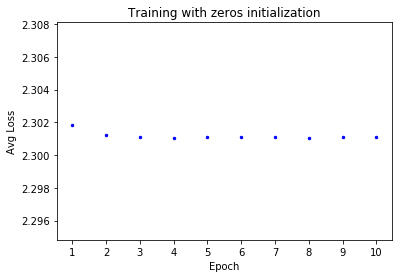

In [27]:
# Plot avg loss / epoch
%matplotlib inline
plot_per_epoch(zeros_losses, "Avg Loss", "Training with zeros initialization")

### Normal

In [43]:
# Compile and train model
mlp_n = MNIST(layers, learning_rate, "normal")
normal_losses = mlp_n.train(10, train_loader, [], [], len(train_loader.dataset))[0]

Epoch 1/10
Avg loss: 102.9132 -- Train acc: 0.9077  
Epoch 2/10
Avg loss: 13.5959 -- Train acc: 0.9570  
Epoch 3/10
Avg loss: 6.8289 -- Train acc: 0.9709  
Epoch 4/10
Avg loss: 3.8098 -- Train acc: 0.9771  
Epoch 5/10
Avg loss: 2.1536 -- Train acc: 0.9794  
Epoch 6/10
Avg loss: 1.2922 -- Train acc: 0.9828  
Epoch 7/10
Avg loss: 0.7900 -- Train acc: 0.9794  
Epoch 8/10
Avg loss: 0.4948 -- Train acc: 0.9936  
Epoch 9/10
Avg loss: 0.3095 -- Train acc: 0.9947  
Epoch 10/10
Avg loss: 0.1884 -- Train acc: 0.9932  
Training done! Elapsed time: 0:00:19



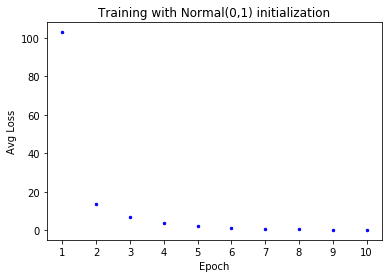

In [44]:
# Plot avg loss / epoch
%matplotlib inline
plot_per_epoch(normal_losses, "Avg Loss", "Training with Normal(0,1) initialization")

### Glorot

In [6]:
# Compile and train model
mlp_g = MNIST(layers, learning_rate, "glorot")
glorot_losses = mlp_g.train(10, train_loader, [], [], len(train_loader.dataset))[0]

Epoch 1/10
Avg loss: 0.8635 -- Train acc: 0.8856  
Epoch 2/10
Avg loss: 0.3712 -- Train acc: 0.9063  
Epoch 3/10
Avg loss: 0.3073 -- Train acc: 0.9191  
Epoch 4/10
Avg loss: 0.2729 -- Train acc: 0.9252  
Epoch 5/10
Avg loss: 0.2475 -- Train acc: 0.9309  
Epoch 6/10
Avg loss: 0.2269 -- Train acc: 0.9380  
Epoch 7/10
Avg loss: 0.2099 -- Train acc: 0.9430  
Epoch 8/10
Avg loss: 0.1944 -- Train acc: 0.9466  
Epoch 9/10
Avg loss: 0.1814 -- Train acc: 0.9495  
Epoch 10/10
Avg loss: 0.1702 -- Train acc: 0.9516  
Training done! Elapsed time: 0:00:19



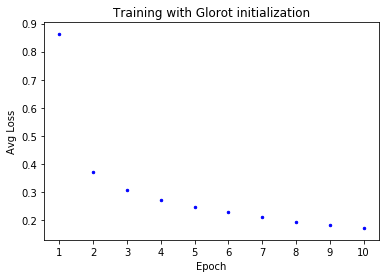

In [7]:
# Plot avg loss / epoch
%matplotlib inline
plot_per_epoch(glorot_losses, "Avg Loss", "Training with Glorot initialization")

### Discussion

TODO: Discuss results

---
## Learning Curves

In [22]:
mlp = MNIST(layers, learning_rate, "glorot")
_, train_acc, valid_acc, _ = mlp.train(100, train_loader, valid_loader, [], len(train_loader.dataset))

Epoch 1/100
Avg loss: 0.8695 -- Train acc: 0.8834 -- Val acc: 0.8924
Epoch 2/100
Avg loss: 0.3749 -- Train acc: 0.9031 -- Val acc: 0.9110
Epoch 3/100
Avg loss: 0.3128 -- Train acc: 0.9174 -- Val acc: 0.9200
Epoch 4/100
Avg loss: 0.2786 -- Train acc: 0.9258 -- Val acc: 0.9271
Epoch 5/100
Avg loss: 0.2530 -- Train acc: 0.9303 -- Val acc: 0.9309
Epoch 6/100
Avg loss: 0.2324 -- Train acc: 0.9365 -- Val acc: 0.9359
Epoch 7/100
Avg loss: 0.2153 -- Train acc: 0.9406 -- Val acc: 0.9401
Epoch 8/100
Avg loss: 0.2004 -- Train acc: 0.9453 -- Val acc: 0.9450
Epoch 9/100
Avg loss: 0.1870 -- Train acc: 0.9477 -- Val acc: 0.9469
Epoch 10/100
Avg loss: 0.1753 -- Train acc: 0.9508 -- Val acc: 0.9477
Epoch 11/100
Avg loss: 0.1652 -- Train acc: 0.9542 -- Val acc: 0.9511
Epoch 12/100
Avg loss: 0.1553 -- Train acc: 0.9570 -- Val acc: 0.9528
Epoch 13/100
Avg loss: 0.1471 -- Train acc: 0.9580 -- Val acc: 0.9542
Epoch 14/100
Avg loss: 0.1392 -- Train acc: 0.9603 -- Val acc: 0.9559
Epoch 15/100
Avg loss: 0.1325

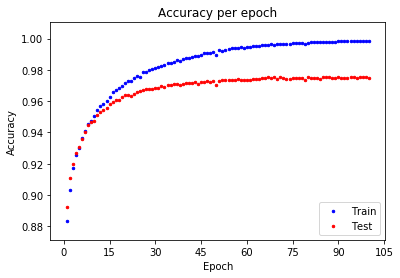

In [24]:
# Plot training and test accuracy / epoch
%matplotlib inline
plots_per_epoch([train_acc, valid_acc], ["Train", "Test"], "Accuracy", "Accuracy per epoch")

We now train by doubling the model capacity. This is done by doubling the number of neurons at the first layer.

In [29]:
num_params = (28*28)*2*512 + 2*512*512 + 512*10
print(num_params)

1332224


In [35]:
layers_2 = [784, 2*512, 512, 10]
mlp_2 = MNIST(layers_2, learning_rate, "glorot")
_, train_acc_2, valid_acc_2, _ = mlp_2.train(100, train_loader, valid_loader, [], len(train_loader.dataset))

Epoch 1/100
Avg loss: 0.8166 -- Train acc: 0.8914 -- Val acc: 0.8975
Epoch 2/100
Avg loss: 0.3595 -- Train acc: 0.9106 -- Val acc: 0.9152
Epoch 3/100
Avg loss: 0.2994 -- Train acc: 0.9216 -- Val acc: 0.9219
Epoch 4/100
Avg loss: 0.2651 -- Train acc: 0.9300 -- Val acc: 0.9298
Epoch 5/100
Avg loss: 0.2398 -- Train acc: 0.9346 -- Val acc: 0.9325
Epoch 6/100
Avg loss: 0.2190 -- Train acc: 0.9401 -- Val acc: 0.9396
Epoch 7/100
Avg loss: 0.2018 -- Train acc: 0.9457 -- Val acc: 0.9456
Epoch 8/100
Avg loss: 0.1872 -- Train acc: 0.9487 -- Val acc: 0.9487
Epoch 9/100
Avg loss: 0.1737 -- Train acc: 0.9536 -- Val acc: 0.9511
Epoch 10/100
Avg loss: 0.1623 -- Train acc: 0.9561 -- Val acc: 0.9541
Epoch 11/100
Avg loss: 0.1521 -- Train acc: 0.9592 -- Val acc: 0.9554
Epoch 12/100
Avg loss: 0.1431 -- Train acc: 0.9610 -- Val acc: 0.9572
Epoch 13/100
Avg loss: 0.1347 -- Train acc: 0.9635 -- Val acc: 0.9584
Epoch 14/100
Avg loss: 0.1274 -- Train acc: 0.9656 -- Val acc: 0.9604
Epoch 15/100
Avg loss: 0.1204

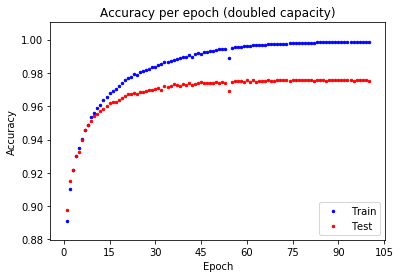

In [37]:
# Plot training and test accuracy / epoch
%matplotlib inline
plots_per_epoch([train_acc_2, valid_acc_2], ["Train", "Test"], "Accuracy", "Accuracy per epoch (doubled capacity)")

### Discussion

TODO: Compare single vs. double capacity.

---
## Training Set Size, Generalization Gap, and Standard Error

For each ratio $a \in \{0.01, 0.02, 0.05, 0.1, 1.0\}$, we reduce the training set to $N_a = aN$ samples, where $N= 50\,000$. We then train using this new dataset.

In [10]:
# Initialize best model so far
mlp = MNIST(layers, learning_rate, "glorot")
ratios = [0.01, 0.02, 0.05, 0.1, 1.0]
nb_epochs = 100
nb_trials = 3

# Generalization gaps
Ga = np.zeros(len(ratios), nb_trials)
             
for i, a in enumerate(ratios):
    length = int(a * len(train_loader.dataset))
    print("%s\na = %.2f, Na = %d\n%s" % ("="*30, a, length, "-"*30))
    
    for j in range(nb_trials):
        print("Iter {:d}".format(j + 1))
        # Subsample from training set
        Na, sub_train_loader = subsample_train(a, train_loader, batch_size)
    
        # Train
        train_loss, train_acc, valid_acc, test_acc = \
            mlp.train(nb_epochs, sub_train_loader, valid_loader, test_loader, Na, gen_gap=True)
            
        # Get best validation epoch
        best_valid = max(valid_acc)
        max_valid_idx = valid_acc.index(best_valid)
        
        # Save generalization gap
        Ga[i,j] = train_acc[max_valid_idx] - test_acc[max_valid_idx]

a = 0.01, Na = 500
------------------------------
Iter 1
Epoch 1/100
Avg loss: 2.3415 -- Train acc: 0.1523 -- Val acc: 0.1544 -- Test acc: 0.1625 -- Gen gap -0.0102
Epoch 2/100
Avg loss: 2.2622 -- Train acc: 0.2656 -- Val acc: 0.2472 -- Test acc: 0.2548 -- Gen gap 0.0108
Epoch 3/100
Avg loss: 2.1935 -- Train acc: 0.4004 -- Val acc: 0.3335 -- Test acc: 0.3392 -- Gen gap 0.0612
Epoch 4/100
Avg loss: 2.1291 -- Train acc: 0.4941 -- Val acc: 0.4179 -- Test acc: 0.4168 -- Gen gap 0.0773
Epoch 5/100
Avg loss: 2.0678 -- Train acc: 0.5664 -- Val acc: 0.4997 -- Test acc: 0.4950 -- Gen gap 0.0714
Epoch 6/100
Avg loss: 2.0076 -- Train acc: 0.6035 -- Val acc: 0.5491 -- Test acc: 0.5462 -- Gen gap 0.0573
Epoch 7/100
Avg loss: 1.9493 -- Train acc: 0.6465 -- Val acc: 0.5905 -- Test acc: 0.5818 -- Gen gap 0.0647
Epoch 8/100
Avg loss: 1.8891 -- Train acc: 0.6816 -- Val acc: 0.6197 -- Test acc: 0.6121 -- Gen gap 0.0696
Epoch 9/100
Avg loss: 1.8319 -- Train acc: 0.7109 -- Val acc: 0.6456 -- Test acc: 0.63

Avg loss: 0.3196 -- Train acc: 0.9180 -- Val acc: 0.8564 -- Test acc: 0.8497 -- Gen gap 0.0682
Epoch 77/100
Avg loss: 0.3158 -- Train acc: 0.9180 -- Val acc: 0.8570 -- Test acc: 0.8510 -- Gen gap 0.0670
Epoch 78/100
Avg loss: 0.3083 -- Train acc: 0.9180 -- Val acc: 0.8566 -- Test acc: 0.8508 -- Gen gap 0.0672
Epoch 79/100
Avg loss: 0.3070 -- Train acc: 0.9180 -- Val acc: 0.8571 -- Test acc: 0.8513 -- Gen gap 0.0667
Epoch 80/100
Avg loss: 0.3038 -- Train acc: 0.9219 -- Val acc: 0.8585 -- Test acc: 0.8532 -- Gen gap 0.0687
Epoch 81/100
Avg loss: 0.2975 -- Train acc: 0.9219 -- Val acc: 0.8578 -- Test acc: 0.8525 -- Gen gap 0.0694
Epoch 82/100
Avg loss: 0.2948 -- Train acc: 0.9238 -- Val acc: 0.8567 -- Test acc: 0.8515 -- Gen gap 0.0723
Epoch 83/100
Avg loss: 0.2893 -- Train acc: 0.9238 -- Val acc: 0.8597 -- Test acc: 0.8543 -- Gen gap 0.0695
Epoch 84/100
Avg loss: 0.2859 -- Train acc: 0.9199 -- Val acc: 0.8595 -- Test acc: 0.8539 -- Gen gap 0.0660
Epoch 85/100
Avg loss: 0.2842 -- Train ac

Avg loss: 0.1843 -- Train acc: 0.9473 -- Val acc: 0.8810 -- Test acc: 0.8754 -- Gen gap 0.0719
Epoch 53/100
Avg loss: 0.1829 -- Train acc: 0.9512 -- Val acc: 0.8811 -- Test acc: 0.8755 -- Gen gap 0.0757
Epoch 54/100
Avg loss: 0.1801 -- Train acc: 0.9492 -- Val acc: 0.8797 -- Test acc: 0.8747 -- Gen gap 0.0745
Epoch 55/100
Avg loss: 0.1767 -- Train acc: 0.9551 -- Val acc: 0.8793 -- Test acc: 0.8747 -- Gen gap 0.0804
Epoch 56/100
Avg loss: 0.1758 -- Train acc: 0.9531 -- Val acc: 0.8792 -- Test acc: 0.8738 -- Gen gap 0.0793
Epoch 57/100
Avg loss: 0.1721 -- Train acc: 0.9570 -- Val acc: 0.8808 -- Test acc: 0.8756 -- Gen gap 0.0814
Epoch 58/100
Avg loss: 0.1704 -- Train acc: 0.9590 -- Val acc: 0.8796 -- Test acc: 0.8754 -- Gen gap 0.0836
Epoch 59/100
Avg loss: 0.1674 -- Train acc: 0.9590 -- Val acc: 0.8801 -- Test acc: 0.8760 -- Gen gap 0.0830
Epoch 60/100
Avg loss: 0.1657 -- Train acc: 0.9609 -- Val acc: 0.8814 -- Test acc: 0.8755 -- Gen gap 0.0854
Epoch 61/100
Avg loss: 0.1644 -- Train ac

Avg loss: 0.2143 -- Train acc: 0.9258 -- Val acc: 0.8856 -- Test acc: 0.8850 -- Gen gap 0.0408
Epoch 29/100
Avg loss: 0.2168 -- Train acc: 0.9238 -- Val acc: 0.8866 -- Test acc: 0.8855 -- Gen gap 0.0383
Epoch 30/100
Avg loss: 0.2125 -- Train acc: 0.9355 -- Val acc: 0.8876 -- Test acc: 0.8860 -- Gen gap 0.0495
Epoch 31/100
Avg loss: 0.2078 -- Train acc: 0.9336 -- Val acc: 0.8882 -- Test acc: 0.8858 -- Gen gap 0.0477
Epoch 32/100
Avg loss: 0.2077 -- Train acc: 0.9375 -- Val acc: 0.8880 -- Test acc: 0.8867 -- Gen gap 0.0508
Epoch 33/100
Avg loss: 0.1993 -- Train acc: 0.9375 -- Val acc: 0.8876 -- Test acc: 0.8861 -- Gen gap 0.0514
Epoch 34/100
Avg loss: 0.1976 -- Train acc: 0.9395 -- Val acc: 0.8879 -- Test acc: 0.8857 -- Gen gap 0.0537
Epoch 35/100
Avg loss: 0.1928 -- Train acc: 0.9395 -- Val acc: 0.8872 -- Test acc: 0.8859 -- Gen gap 0.0535
Epoch 36/100
Avg loss: 0.1918 -- Train acc: 0.9395 -- Val acc: 0.8874 -- Test acc: 0.8864 -- Gen gap 0.0530
Epoch 37/100
Avg loss: 0.1892 -- Train ac

Avg loss: 0.3424 -- Train acc: 0.8848 -- Val acc: 0.8954 -- Test acc: 0.8925 -- Gen gap -0.0078
Epoch 4/100
Avg loss: 0.3295 -- Train acc: 0.8838 -- Val acc: 0.8956 -- Test acc: 0.8939 -- Gen gap -0.0101
Epoch 5/100
Avg loss: 0.3200 -- Train acc: 0.8906 -- Val acc: 0.8985 -- Test acc: 0.8947 -- Gen gap -0.0041
Epoch 6/100
Avg loss: 0.3012 -- Train acc: 0.8955 -- Val acc: 0.8986 -- Test acc: 0.8953 -- Gen gap 0.0002
Epoch 7/100
Avg loss: 0.3041 -- Train acc: 0.8936 -- Val acc: 0.8974 -- Test acc: 0.8950 -- Gen gap -0.0014
Epoch 8/100
Avg loss: 0.2852 -- Train acc: 0.8984 -- Val acc: 0.9008 -- Test acc: 0.8983 -- Gen gap 0.0001
Epoch 9/100
Avg loss: 0.2808 -- Train acc: 0.9043 -- Val acc: 0.9006 -- Test acc: 0.8976 -- Gen gap 0.0067
Epoch 10/100
Avg loss: 0.2709 -- Train acc: 0.9082 -- Val acc: 0.9014 -- Test acc: 0.8960 -- Gen gap 0.0122
Epoch 11/100
Avg loss: 0.2639 -- Train acc: 0.9082 -- Val acc: 0.9022 -- Test acc: 0.8987 -- Gen gap 0.0095
Epoch 12/100
Avg loss: 0.2644 -- Train acc:

Avg loss: 0.0871 -- Train acc: 0.9668 -- Val acc: 0.9065 -- Test acc: 0.9012 -- Gen gap 0.0656
Epoch 80/100
Avg loss: 0.0830 -- Train acc: 0.9697 -- Val acc: 0.9078 -- Test acc: 0.9023 -- Gen gap 0.0675
Epoch 81/100
Avg loss: 0.0827 -- Train acc: 0.9697 -- Val acc: 0.9077 -- Test acc: 0.9021 -- Gen gap 0.0677
Epoch 82/100
Avg loss: 0.0818 -- Train acc: 0.9697 -- Val acc: 0.9084 -- Test acc: 0.9025 -- Gen gap 0.0673
Epoch 83/100
Avg loss: 0.0812 -- Train acc: 0.9697 -- Val acc: 0.9085 -- Test acc: 0.9019 -- Gen gap 0.0679
Epoch 84/100
Avg loss: 0.0800 -- Train acc: 0.9697 -- Val acc: 0.9088 -- Test acc: 0.9014 -- Gen gap 0.0684
Epoch 85/100
Avg loss: 0.0786 -- Train acc: 0.9697 -- Val acc: 0.9074 -- Test acc: 0.9011 -- Gen gap 0.0687
Epoch 86/100
Avg loss: 0.0777 -- Train acc: 0.9697 -- Val acc: 0.9080 -- Test acc: 0.9018 -- Gen gap 0.0680
Epoch 87/100
Avg loss: 0.0762 -- Train acc: 0.9697 -- Val acc: 0.9074 -- Test acc: 0.9024 -- Gen gap 0.0674
Epoch 88/100
Avg loss: 0.0752 -- Train ac

Avg loss: 0.0890 -- Train acc: 0.9629 -- Val acc: 0.9116 -- Test acc: 0.9102 -- Gen gap 0.0527
Epoch 56/100
Avg loss: 0.0892 -- Train acc: 0.9658 -- Val acc: 0.9114 -- Test acc: 0.9094 -- Gen gap 0.0564
Epoch 57/100
Avg loss: 0.0870 -- Train acc: 0.9639 -- Val acc: 0.9109 -- Test acc: 0.9093 -- Gen gap 0.0545
Epoch 58/100
Avg loss: 0.0858 -- Train acc: 0.9648 -- Val acc: 0.9103 -- Test acc: 0.9097 -- Gen gap 0.0551
Epoch 59/100
Avg loss: 0.0835 -- Train acc: 0.9658 -- Val acc: 0.9109 -- Test acc: 0.9100 -- Gen gap 0.0558
Epoch 60/100
Avg loss: 0.0820 -- Train acc: 0.9658 -- Val acc: 0.9107 -- Test acc: 0.9095 -- Gen gap 0.0563
Epoch 61/100
Avg loss: 0.0811 -- Train acc: 0.9658 -- Val acc: 0.9102 -- Test acc: 0.9097 -- Gen gap 0.0561
Epoch 62/100
Avg loss: 0.0798 -- Train acc: 0.9688 -- Val acc: 0.9094 -- Test acc: 0.9096 -- Gen gap 0.0591
Epoch 63/100
Avg loss: 0.0777 -- Train acc: 0.9688 -- Val acc: 0.9100 -- Test acc: 0.9092 -- Gen gap 0.0595
Epoch 64/100
Avg loss: 0.0791 -- Train ac

Avg loss: 0.1121 -- Train acc: 0.9590 -- Val acc: 0.9188 -- Test acc: 0.9154 -- Gen gap 0.0436
Epoch 32/100
Avg loss: 0.1102 -- Train acc: 0.9609 -- Val acc: 0.9187 -- Test acc: 0.9154 -- Gen gap 0.0455
Epoch 33/100
Avg loss: 0.1107 -- Train acc: 0.9619 -- Val acc: 0.9188 -- Test acc: 0.9145 -- Gen gap 0.0474
Epoch 34/100
Avg loss: 0.1058 -- Train acc: 0.9639 -- Val acc: 0.9188 -- Test acc: 0.9148 -- Gen gap 0.0491
Epoch 35/100
Avg loss: 0.1034 -- Train acc: 0.9629 -- Val acc: 0.9187 -- Test acc: 0.9144 -- Gen gap 0.0485
Epoch 36/100
Avg loss: 0.1041 -- Train acc: 0.9639 -- Val acc: 0.9167 -- Test acc: 0.9145 -- Gen gap 0.0494
Epoch 37/100
Avg loss: 0.0989 -- Train acc: 0.9648 -- Val acc: 0.9191 -- Test acc: 0.9156 -- Gen gap 0.0492
Epoch 38/100
Avg loss: 0.0987 -- Train acc: 0.9639 -- Val acc: 0.9184 -- Test acc: 0.9157 -- Gen gap 0.0482
Epoch 39/100
Avg loss: 0.0958 -- Train acc: 0.9648 -- Val acc: 0.9185 -- Test acc: 0.9155 -- Gen gap 0.0493
Epoch 40/100
Avg loss: 0.0935 -- Train ac

Avg loss: 0.1943 -- Train acc: 0.9211 -- Val acc: 0.9271 -- Test acc: 0.9213 -- Gen gap -0.0002
Epoch 7/100
Avg loss: 0.1843 -- Train acc: 0.9273 -- Val acc: 0.9306 -- Test acc: 0.9264 -- Gen gap 0.0010
Epoch 8/100
Avg loss: 0.1767 -- Train acc: 0.9309 -- Val acc: 0.9318 -- Test acc: 0.9259 -- Gen gap 0.0050
Epoch 9/100
Avg loss: 0.1704 -- Train acc: 0.9320 -- Val acc: 0.9303 -- Test acc: 0.9259 -- Gen gap 0.0062
Epoch 10/100
Avg loss: 0.1646 -- Train acc: 0.9355 -- Val acc: 0.9326 -- Test acc: 0.9271 -- Gen gap 0.0084
Epoch 11/100
Avg loss: 0.1625 -- Train acc: 0.9352 -- Val acc: 0.9315 -- Test acc: 0.9274 -- Gen gap 0.0077
Epoch 12/100
Avg loss: 0.1532 -- Train acc: 0.9402 -- Val acc: 0.9332 -- Test acc: 0.9279 -- Gen gap 0.0123
Epoch 13/100
Avg loss: 0.1472 -- Train acc: 0.9414 -- Val acc: 0.9318 -- Test acc: 0.9280 -- Gen gap 0.0134
Epoch 14/100
Avg loss: 0.1430 -- Train acc: 0.9410 -- Val acc: 0.9322 -- Test acc: 0.9278 -- Gen gap 0.0132
Epoch 15/100
Avg loss: 0.1457 -- Train acc:

Avg loss: 0.0400 -- Train acc: 0.9734 -- Val acc: 0.9364 -- Test acc: 0.9318 -- Gen gap 0.0416
Epoch 83/100
Avg loss: 0.0398 -- Train acc: 0.9738 -- Val acc: 0.9359 -- Test acc: 0.9317 -- Gen gap 0.0421
Epoch 84/100
Avg loss: 0.0399 -- Train acc: 0.9738 -- Val acc: 0.9353 -- Test acc: 0.9321 -- Gen gap 0.0417
Epoch 85/100
Avg loss: 0.0388 -- Train acc: 0.9738 -- Val acc: 0.9365 -- Test acc: 0.9319 -- Gen gap 0.0419
Epoch 86/100
Avg loss: 0.0379 -- Train acc: 0.9738 -- Val acc: 0.9359 -- Test acc: 0.9322 -- Gen gap 0.0416
Epoch 87/100
Avg loss: 0.0373 -- Train acc: 0.9738 -- Val acc: 0.9367 -- Test acc: 0.9319 -- Gen gap 0.0419
Epoch 88/100
Avg loss: 0.0369 -- Train acc: 0.9738 -- Val acc: 0.9364 -- Test acc: 0.9313 -- Gen gap 0.0425
Epoch 89/100
Avg loss: 0.0367 -- Train acc: 0.9734 -- Val acc: 0.9353 -- Test acc: 0.9315 -- Gen gap 0.0419
Epoch 90/100
Avg loss: 0.0365 -- Train acc: 0.9730 -- Val acc: 0.9351 -- Test acc: 0.9310 -- Gen gap 0.0420
Epoch 91/100
Avg loss: 0.0357 -- Train ac

Avg loss: 0.0327 -- Train acc: 0.9738 -- Val acc: 0.9398 -- Test acc: 0.9375 -- Gen gap 0.0363
Epoch 59/100
Avg loss: 0.0318 -- Train acc: 0.9742 -- Val acc: 0.9397 -- Test acc: 0.9371 -- Gen gap 0.0371
Epoch 60/100
Avg loss: 0.0317 -- Train acc: 0.9742 -- Val acc: 0.9397 -- Test acc: 0.9379 -- Gen gap 0.0363
Epoch 61/100
Avg loss: 0.0307 -- Train acc: 0.9742 -- Val acc: 0.9400 -- Test acc: 0.9379 -- Gen gap 0.0363
Epoch 62/100
Avg loss: 0.0310 -- Train acc: 0.9742 -- Val acc: 0.9393 -- Test acc: 0.9360 -- Gen gap 0.0382
Epoch 63/100
Avg loss: 0.0298 -- Train acc: 0.9742 -- Val acc: 0.9400 -- Test acc: 0.9374 -- Gen gap 0.0368
Epoch 64/100
Avg loss: 0.0299 -- Train acc: 0.9742 -- Val acc: 0.9397 -- Test acc: 0.9367 -- Gen gap 0.0375
Epoch 65/100
Avg loss: 0.0294 -- Train acc: 0.9746 -- Val acc: 0.9398 -- Test acc: 0.9376 -- Gen gap 0.0370
Epoch 66/100
Avg loss: 0.0295 -- Train acc: 0.9750 -- Val acc: 0.9397 -- Test acc: 0.9375 -- Gen gap 0.0375
Epoch 67/100
Avg loss: 0.0285 -- Train ac

Avg loss: 0.0542 -- Train acc: 0.9695 -- Val acc: 0.9439 -- Test acc: 0.9431 -- Gen gap 0.0265
Epoch 35/100
Avg loss: 0.0516 -- Train acc: 0.9691 -- Val acc: 0.9464 -- Test acc: 0.9429 -- Gen gap 0.0263
Epoch 36/100
Avg loss: 0.0506 -- Train acc: 0.9703 -- Val acc: 0.9457 -- Test acc: 0.9449 -- Gen gap 0.0254
Epoch 37/100
Avg loss: 0.0489 -- Train acc: 0.9711 -- Val acc: 0.9458 -- Test acc: 0.9438 -- Gen gap 0.0273
Epoch 38/100
Avg loss: 0.0484 -- Train acc: 0.9676 -- Val acc: 0.9438 -- Test acc: 0.9414 -- Gen gap 0.0262
Epoch 39/100
Avg loss: 0.0471 -- Train acc: 0.9715 -- Val acc: 0.9457 -- Test acc: 0.9437 -- Gen gap 0.0278
Epoch 40/100
Avg loss: 0.0468 -- Train acc: 0.9703 -- Val acc: 0.9464 -- Test acc: 0.9448 -- Gen gap 0.0255
Epoch 41/100
Avg loss: 0.0450 -- Train acc: 0.9715 -- Val acc: 0.9464 -- Test acc: 0.9442 -- Gen gap 0.0273
Epoch 42/100
Avg loss: 0.0458 -- Train acc: 0.9684 -- Val acc: 0.9435 -- Test acc: 0.9390 -- Gen gap 0.0294
Epoch 43/100
Avg loss: 0.0448 -- Train ac

Avg loss: 0.0877 -- Train acc: 0.9660 -- Val acc: 0.9505 -- Test acc: 0.9495 -- Gen gap 0.0164
Epoch 10/100
Avg loss: 0.0907 -- Train acc: 0.9680 -- Val acc: 0.9484 -- Test acc: 0.9473 -- Gen gap 0.0207
Epoch 11/100
Avg loss: 0.0802 -- Train acc: 0.9705 -- Val acc: 0.9509 -- Test acc: 0.9481 -- Gen gap 0.0224
Epoch 12/100
Avg loss: 0.0766 -- Train acc: 0.9701 -- Val acc: 0.9504 -- Test acc: 0.9495 -- Gen gap 0.0206
Epoch 13/100
Avg loss: 0.0743 -- Train acc: 0.9717 -- Val acc: 0.9486 -- Test acc: 0.9479 -- Gen gap 0.0239
Epoch 14/100
Avg loss: 0.0703 -- Train acc: 0.9715 -- Val acc: 0.9502 -- Test acc: 0.9506 -- Gen gap 0.0209
Epoch 15/100
Avg loss: 0.0673 -- Train acc: 0.9747 -- Val acc: 0.9514 -- Test acc: 0.9504 -- Gen gap 0.0242
Epoch 16/100
Avg loss: 0.0649 -- Train acc: 0.9747 -- Val acc: 0.9504 -- Test acc: 0.9515 -- Gen gap 0.0232
Epoch 17/100
Avg loss: 0.0637 -- Train acc: 0.9757 -- Val acc: 0.9504 -- Test acc: 0.9511 -- Gen gap 0.0245
Epoch 18/100
Avg loss: 0.0615 -- Train ac

Avg loss: 0.0143 -- Train acc: 0.9889 -- Val acc: 0.9538 -- Test acc: 0.9527 -- Gen gap 0.0362
Epoch 86/100
Avg loss: 0.0141 -- Train acc: 0.9889 -- Val acc: 0.9536 -- Test acc: 0.9530 -- Gen gap 0.0359
Epoch 87/100
Avg loss: 0.0139 -- Train acc: 0.9889 -- Val acc: 0.9540 -- Test acc: 0.9518 -- Gen gap 0.0371
Epoch 88/100
Avg loss: 0.0139 -- Train acc: 0.9887 -- Val acc: 0.9536 -- Test acc: 0.9519 -- Gen gap 0.0368
Epoch 89/100
Avg loss: 0.0136 -- Train acc: 0.9889 -- Val acc: 0.9540 -- Test acc: 0.9529 -- Gen gap 0.0360
Epoch 90/100
Avg loss: 0.0134 -- Train acc: 0.9889 -- Val acc: 0.9536 -- Test acc: 0.9526 -- Gen gap 0.0363
Epoch 91/100
Avg loss: 0.0132 -- Train acc: 0.9889 -- Val acc: 0.9537 -- Test acc: 0.9531 -- Gen gap 0.0358
Epoch 92/100
Avg loss: 0.0134 -- Train acc: 0.9889 -- Val acc: 0.9539 -- Test acc: 0.9533 -- Gen gap 0.0356
Epoch 93/100
Avg loss: 0.0129 -- Train acc: 0.9889 -- Val acc: 0.9541 -- Test acc: 0.9529 -- Gen gap 0.0360
Epoch 94/100
Avg loss: 0.0127 -- Train ac

Avg loss: 0.0188 -- Train acc: 0.9883 -- Val acc: 0.9587 -- Test acc: 0.9575 -- Gen gap 0.0308
Epoch 62/100
Avg loss: 0.0184 -- Train acc: 0.9883 -- Val acc: 0.9584 -- Test acc: 0.9570 -- Gen gap 0.0313
Epoch 63/100
Avg loss: 0.0186 -- Train acc: 0.9881 -- Val acc: 0.9590 -- Test acc: 0.9566 -- Gen gap 0.0315
Epoch 64/100
Avg loss: 0.0180 -- Train acc: 0.9883 -- Val acc: 0.9579 -- Test acc: 0.9576 -- Gen gap 0.0307
Epoch 65/100
Avg loss: 0.0175 -- Train acc: 0.9885 -- Val acc: 0.9585 -- Test acc: 0.9572 -- Gen gap 0.0313
Epoch 66/100
Avg loss: 0.0174 -- Train acc: 0.9885 -- Val acc: 0.9587 -- Test acc: 0.9573 -- Gen gap 0.0312
Epoch 67/100
Avg loss: 0.0168 -- Train acc: 0.9885 -- Val acc: 0.9586 -- Test acc: 0.9571 -- Gen gap 0.0314
Epoch 68/100
Avg loss: 0.0168 -- Train acc: 0.9885 -- Val acc: 0.9589 -- Test acc: 0.9575 -- Gen gap 0.0310
Epoch 69/100
Avg loss: 0.0165 -- Train acc: 0.9885 -- Val acc: 0.9581 -- Test acc: 0.9572 -- Gen gap 0.0313
Epoch 70/100
Avg loss: 0.0163 -- Train ac

Avg loss: 0.0158 -- Train acc: 0.9881 -- Val acc: 0.9605 -- Test acc: 0.9610 -- Gen gap 0.0271
Epoch 38/100
Avg loss: 0.0158 -- Train acc: 0.9883 -- Val acc: 0.9604 -- Test acc: 0.9612 -- Gen gap 0.0271
Epoch 39/100
Avg loss: 0.0154 -- Train acc: 0.9883 -- Val acc: 0.9606 -- Test acc: 0.9612 -- Gen gap 0.0271
Epoch 40/100
Avg loss: 0.0150 -- Train acc: 0.9883 -- Val acc: 0.9597 -- Test acc: 0.9610 -- Gen gap 0.0273
Epoch 41/100
Avg loss: 0.0145 -- Train acc: 0.9883 -- Val acc: 0.9595 -- Test acc: 0.9609 -- Gen gap 0.0274
Epoch 42/100
Avg loss: 0.0142 -- Train acc: 0.9883 -- Val acc: 0.9604 -- Test acc: 0.9611 -- Gen gap 0.0272
Epoch 43/100
Avg loss: 0.0140 -- Train acc: 0.9883 -- Val acc: 0.9600 -- Test acc: 0.9616 -- Gen gap 0.0267
Epoch 44/100
Avg loss: 0.0137 -- Train acc: 0.9883 -- Val acc: 0.9601 -- Test acc: 0.9611 -- Gen gap 0.0272
Epoch 45/100
Avg loss: 0.0138 -- Train acc: 0.9879 -- Val acc: 0.9589 -- Test acc: 0.9605 -- Gen gap 0.0274
Epoch 46/100
Avg loss: 0.0133 -- Train ac

Avg loss: 0.0407 -- Train acc: 0.9891 -- Val acc: 0.9709 -- Test acc: 0.9693 -- Gen gap 0.0198
Epoch 13/100
Avg loss: 0.0390 -- Train acc: 0.9900 -- Val acc: 0.9719 -- Test acc: 0.9694 -- Gen gap 0.0206
Epoch 14/100
Avg loss: 0.0375 -- Train acc: 0.9908 -- Val acc: 0.9718 -- Test acc: 0.9697 -- Gen gap 0.0210
Epoch 15/100
Avg loss: 0.0358 -- Train acc: 0.9915 -- Val acc: 0.9723 -- Test acc: 0.9705 -- Gen gap 0.0209
Epoch 16/100
Avg loss: 0.0345 -- Train acc: 0.9918 -- Val acc: 0.9725 -- Test acc: 0.9701 -- Gen gap 0.0217
Epoch 17/100
Avg loss: 0.0332 -- Train acc: 0.9925 -- Val acc: 0.9724 -- Test acc: 0.9702 -- Gen gap 0.0222
Epoch 18/100
Avg loss: 0.0319 -- Train acc: 0.9919 -- Val acc: 0.9711 -- Test acc: 0.9707 -- Gen gap 0.0212
Epoch 19/100
Avg loss: 0.0306 -- Train acc: 0.9930 -- Val acc: 0.9719 -- Test acc: 0.9708 -- Gen gap 0.0222
Epoch 20/100
Avg loss: 0.0295 -- Train acc: 0.9938 -- Val acc: 0.9722 -- Test acc: 0.9710 -- Gen gap 0.0228
Epoch 21/100
Avg loss: 0.0286 -- Train ac

Avg loss: 0.0047 -- Train acc: 0.9990 -- Val acc: 0.9750 -- Test acc: 0.9748 -- Gen gap 0.0241
Epoch 89/100
Avg loss: 0.0046 -- Train acc: 0.9990 -- Val acc: 0.9751 -- Test acc: 0.9742 -- Gen gap 0.0248
Epoch 90/100
Avg loss: 0.0045 -- Train acc: 0.9990 -- Val acc: 0.9754 -- Test acc: 0.9743 -- Gen gap 0.0247
Epoch 91/100
Avg loss: 0.0045 -- Train acc: 0.9990 -- Val acc: 0.9750 -- Test acc: 0.9742 -- Gen gap 0.0248
Epoch 92/100
Avg loss: 0.0044 -- Train acc: 0.9990 -- Val acc: 0.9752 -- Test acc: 0.9740 -- Gen gap 0.0250
Epoch 93/100
Avg loss: 0.0043 -- Train acc: 0.9990 -- Val acc: 0.9749 -- Test acc: 0.9744 -- Gen gap 0.0246
Epoch 94/100
Avg loss: 0.0042 -- Train acc: 0.9990 -- Val acc: 0.9753 -- Test acc: 0.9738 -- Gen gap 0.0252
Epoch 95/100
Avg loss: 0.0042 -- Train acc: 0.9990 -- Val acc: 0.9748 -- Test acc: 0.9743 -- Gen gap 0.0247
Epoch 96/100
Avg loss: 0.0041 -- Train acc: 0.9990 -- Val acc: 0.9754 -- Test acc: 0.9740 -- Gen gap 0.0250
Epoch 97/100
Avg loss: 0.0040 -- Train ac

Avg loss: 0.0018 -- Train acc: 0.9990 -- Val acc: 0.9752 -- Test acc: 0.9748 -- Gen gap 0.0242
Epoch 65/100
Avg loss: 0.0018 -- Train acc: 0.9990 -- Val acc: 0.9751 -- Test acc: 0.9753 -- Gen gap 0.0237
Epoch 66/100
Avg loss: 0.0018 -- Train acc: 0.9990 -- Val acc: 0.9755 -- Test acc: 0.9746 -- Gen gap 0.0244
Epoch 67/100
Avg loss: 0.0018 -- Train acc: 0.9990 -- Val acc: 0.9755 -- Test acc: 0.9748 -- Gen gap 0.0242
Epoch 68/100
Avg loss: 0.0017 -- Train acc: 0.9990 -- Val acc: 0.9755 -- Test acc: 0.9752 -- Gen gap 0.0238
Epoch 69/100
Avg loss: 0.0017 -- Train acc: 0.9990 -- Val acc: 0.9757 -- Test acc: 0.9749 -- Gen gap 0.0241
Epoch 70/100
Avg loss: 0.0017 -- Train acc: 0.9990 -- Val acc: 0.9756 -- Test acc: 0.9747 -- Gen gap 0.0243
Epoch 71/100
Avg loss: 0.0017 -- Train acc: 0.9990 -- Val acc: 0.9752 -- Test acc: 0.9750 -- Gen gap 0.0240
Epoch 72/100
Avg loss: 0.0017 -- Train acc: 0.9990 -- Val acc: 0.9759 -- Test acc: 0.9747 -- Gen gap 0.0243
Epoch 73/100
Avg loss: 0.0017 -- Train ac

Avg loss: 0.0010 -- Train acc: 0.9990 -- Val acc: 0.9752 -- Test acc: 0.9751 -- Gen gap 0.0239
Epoch 41/100
Avg loss: 0.0010 -- Train acc: 0.9990 -- Val acc: 0.9755 -- Test acc: 0.9750 -- Gen gap 0.0240
Epoch 42/100
Avg loss: 0.0010 -- Train acc: 0.9990 -- Val acc: 0.9752 -- Test acc: 0.9752 -- Gen gap 0.0238
Epoch 43/100
Avg loss: 0.0010 -- Train acc: 0.9990 -- Val acc: 0.9755 -- Test acc: 0.9750 -- Gen gap 0.0240
Epoch 44/100
Avg loss: 0.0010 -- Train acc: 0.9990 -- Val acc: 0.9753 -- Test acc: 0.9751 -- Gen gap 0.0239
Epoch 45/100
Avg loss: 0.0010 -- Train acc: 0.9990 -- Val acc: 0.9754 -- Test acc: 0.9752 -- Gen gap 0.0238
Epoch 46/100
Avg loss: 0.0010 -- Train acc: 0.9990 -- Val acc: 0.9753 -- Test acc: 0.9750 -- Gen gap 0.0240
Epoch 47/100
Avg loss: 0.0010 -- Train acc: 0.9990 -- Val acc: 0.9755 -- Test acc: 0.9750 -- Gen gap 0.0240
Epoch 48/100
Avg loss: 0.0010 -- Train acc: 0.9990 -- Val acc: 0.9754 -- Test acc: 0.9751 -- Gen gap 0.0239
Epoch 49/100
Avg loss: 0.0010 -- Train ac

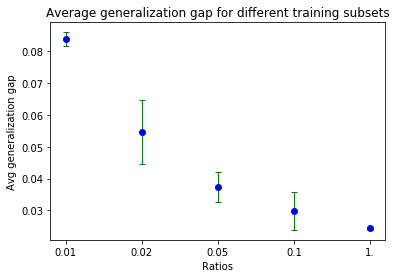

In [38]:
means, stds = Ga.mean(1), Ga.std(1)
labels = ["0.01","0.02","0.05","0.1","1."]
plot_error_bars(labels, means, stds, "Ratios", "Avg generalization gap",
    "Average generalization gap for different training subsets")

### Discussion

TODO: Discuss this.